<a href="https://colab.research.google.com/github/vkt1414/Cloud-Resources-Workflows/blob/main/Notebooks/Totalsegmentator/downloadDicomAndConvertNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This Notebook does the first step in the split workflow on Terra 
DICOM files are downloaded from IDC and converted to NIFTI files with dcm2niix or plastimatch. Whenever there are multiple NIFTI files for a series, such series are prohibited from continuing to Inference. A CSV file is created with a list of such series.

Please cite:

Li X, Morgan PS, Ashburner J, Smith J, Rorden C. (2016) The first step for neuroimaging data analysis: DICOM to NIfTI conversion. J Neurosci Methods. 264:47-56.

Shackleford, James A., Nagarajan Kandasamy and Gregory C. Sharp. “Plastimatch—An Open-Source Software for Radiotherapy Imaging.” (2014).



###Installing Packages

In [49]:
%%capture
#Installing dcm2niix
!apt-get install dcm2niix pigz

In [50]:
%%capture
#Installing plastimatch
!apt-get install plastimatch 

In [51]:
%%capture
#install s5cmd
!wget "https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz"
!tar -xvzf "s5cmd_2.0.0_Linux-64bit.tar.gz"
!rm "s5cmd_2.0.0_Linux-64bit.tar.gz"
!mv s5cmd /usr/local/bin/s5cmd

In [52]:
import os
import sys
import time
import pandas as pd
from pathlib import Path
import shutil

In [53]:
curr_dir   = Path().absolute()

print(time.asctime(time.localtime()))
print("\nCurrent directory :{}".format( curr_dir))
print("Python version    :", sys.version.split('\n')[0])

Tue Mar 21 20:00:13 2023

Current directory :/content
Python version    : 3.9.16 (main, Dec  7 2022, 01:11:51) 


###Reading CSV File containing s5cmd Urls

In [54]:
#get the path of the zip file containing csv file in the current working directory3
#In Terra, a zip file containing the csv file will be provided as input and will be localized
#to the current working directory.

#Since it will be the only zip file that will be provided as input, we will be unzipping 
#the first zip file in the current working directory.

import glob

#zip_file_path = glob.glob('*.zip')[0]
#zip_file_path='/content/drive/MyDrive/result.zip'
#!unzip $zip_file_path

#csv_file_path = glob.glob('*.csv')[0]
#csv_file_path= '/home/vamsi/Downloads/result.csv'

start_time = time.time()
#cohort_df=pd.read_csv(csv_file_path, delimiter=',', encoding='utf-8')
cohort_df= pd.read_csv('/content/drive/MyDrive/bquxjob_7f0d87d5_187056e0dd3.csv')
read_time=time.time() -start_time
print('read in '+str(read_time)+ '  seconds')

read in 0.013532161712646484  seconds


In [55]:
#SeriesInstanceUIDs= cohort_df["SeriesInstanceUID"].values.tolist()
SeriesInstanceUIDs=[
# '1.3.6.1.4.1.14519.5.2.1.7009.9004.100143549999116733615345241533',
# '1.3.6.1.4.1.14519.5.2.1.7009.9004.100148350742920339334061834697',
#series that create two volumes
'1.3.6.1.4.1.14519.5.2.1.7009.9004.946109466334058509440732472138',
'1.2.840.113654.2.55.99651797089556982668213819691341139949'  
]

###Defining Functions

In [56]:
#Creating Directories
!rm -r dcm2niix plastimatch
!mkdir dcm2niix plastimatch

In [57]:
def download_dicom_data(series_id):

  """
  Download raw DICOM data into "idc_data" folder.
  """
  global cohort_df
  gs_file_path = "s5cmd_manifest.txt"
  #when bigquery is used the following line could be used
  #cohort_df = bq_client.query(selection_query).to_dataframe()
  series_df=cohort_df[cohort_df['SeriesInstanceUID']==series_id]
  series_df["s5cmdUrls"].to_csv(gs_file_path, header = False, index = False)
  #remove double quotes from the manifest file
  !sed -i 's/"//g' s5cmd_manifest.txt  

  start_time = time.time()
  print("Copying files from IDC buckets..")

  #!cat $gs_file_path | gsutil -q -m cp -Ir $download_path >> /dev/null
  !s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run s5cmd_manifest.txt  >> /dev/null

  elapsed = time.time() - start_time
  print("Done in %g seconds."%elapsed)

In [58]:
def convert_dicom_to_nifti(series_id):
  try:
    shutil.rmtree(f'dcm2niix/{series_id}')
  except OSError:
    pass
  os.mkdir(f'dcm2niix/{series_id}')

  !dcm2niix -z y -f %j_%p_%t_%s -b n -m y -o  /{curr_dir}/dcm2niix/{series_id}  /{curr_dir}/idc_data/
  # try:
  #   shutil.rmtree(f'plastimatch/{series_id}')
  # except OSError:
  #   pass
  # os.mkdir(f'plastimatch/{series_id}')
  # !plastimatch convert --input /{curr_dir}/idc_data/ --output-img /{curr_dir}/plastimatch/{series_id}/{series_id}.nii.gz


  try:
      shutil.rmtree('idc_data')
  except OSError:
      pass
  os.mkdir('idc_data')

In [59]:
import os
import zipfile
from concurrent.futures import ThreadPoolExecutor
from time import sleep
from datetime import datetime
import psutil
import pandas as pd
import matplotlib.pyplot as plt

class MemoryMonitor:
    def __init__(self):
        self.keep_measuring = True

    def measure_usage(self):
        cpu_usage = []
        ram_usage_mb=[]
        time_stamps = []
        start_time = time.time()
        while self.keep_measuring:
            cpu = psutil.cpu_percent()
            ram = psutil.virtual_memory()
            ram_total_mb = psutil.virtual_memory().total / 1024 / 1024
            ram_mb = (ram.total - ram.available) / 1024 / 1024

            cpu_usage.append(cpu)
            ram_usage_mb.append(ram_mb)
            time_stamps.append(time.time()- start_time)
            sleep(1)

        return cpu_usage, ram_usage_mb, time_stamps, ram_total_mb

In [60]:
def download_and_process_series(series_id):
    log = pd.DataFrame({'SeriesInstanceUID': [series_id]})

    start_time = time.time()
    download_dicom_data( series_id)
    download_time = time.time() - start_time

    log['download_time'] = download_time

    start_time = time.time()
    convert_dicom_to_nifti(series_id)
    convert_dicom_to_nifti_time = time.time() - start_time

    log['NiftiConverter_time'] = convert_dicom_to_nifti_time

    global runtime_stats
    runtime_stats = pd.concat([runtime_stats, log], ignore_index=True, axis=0)



###Downloading and Converting

Copying files from IDC buckets..
Done in 1.131 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 256 DICOM file(s)
Dims 512 512 256 1 1
 Distance from first slice:
dx=[0 1.25 2.5 3.75 5 6.25 7.5 8.75 10 11.25 12.5 13.75 15 16.25 17.5 18.75 20 21.25 22.5 23.75 25 26.25 27.5 28.75 30 31.25 32.5 33.75 35 36.25 37.5 38.75 40 41.25 42.5 43.75 45 46.25 47.5 48.75 50 51.25 52.5 53.75 55 56.25 57.5 58.75 60 61.25 62.5 63.75 65 66.25 67.5 68.75 70 71.25 72.5 73.75 75 76.25 77.5 78.75 80 81.25 82.5 83.75 85 86.25 87.5 88.75 90 91.25 92.5 93.75 95 96.25 97.5 98.75 100 101.25 102.5 103.75 105 106.25 107.5 108.75 110 111.25 112.5 113.75 115 116.25 117.5 118.75 120 121.25 122.5 123.75 125 126.25 127.5 128.75 130 131.25 132.5 133.75 135 136.25 137.5 138.75 140 141.25 142.5 143.75 145 146.25 147.5 148.75 150 151.25 152.5 153.75 155 156.25 157.5 158.75 160 161.25 162.5 163.75 165 166.25 167.5 168.75 170 171.25 172.5 173.75 175 176.25 177.5 178.75 180 1

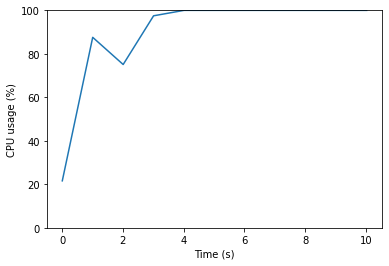

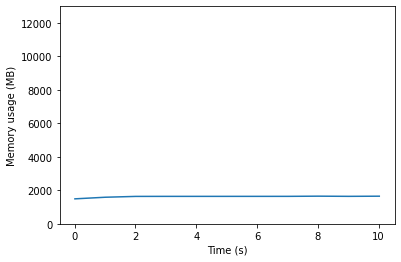

Copying files from IDC buckets..
Done in 0.833477 seconds.
Chris Rorden's dcm2niiX version v1.0.20181125  (JP2:OpenJPEG) GCC9.3.0 (64-bit Linux)
Found 128 DICOM file(s)
Dims 512 512 128 1 1
 Distance from first slice:
dx=[0 2.5 5 7.5 10 12.5 15 17.5 20 22.5 25 27.5 30 32.5 35 37.5 40 42.5 45 47.5 50 52.5 55 57.5 60 62.5 65 67.5 70 72.5 75 77.5 80 82.5 85 87.5 90 92.5 95 97.5 100 102.5 105 107.5 110 112.5 115 117.5 120 122.5 125 127.5 130 132.5 135 137.5 140 142.5 145 147.5 150 152.5 155 157.5 160 162.5 165 167.5 170 172.5 175 177.5 180 182.5 185 187.5 190 192.5 195 197.5 200 202.5 205 207.5 210 212.5 215 217.5 220 222.5 225 227.5 230 232.5 235 237.5 240 242.5 245 247.5 250 252.5 255 257.5 260 262.5 265 267.5 270 272.5 275 277.5 280 282.5 285 2.54001 5.04001 7.54001 10.04 12.54 15.04 17.54 20.04 22.54 25.04 27.54 30.04 32.54]
Convert 128 DICOM as //content/dcm2niix/1.2.840.113654.2.55.99651797089556982668213819691341139949/1.2.840.113654.2.55.99651797089556982668213819691341139949_0_OPA

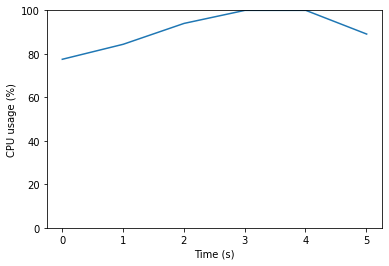

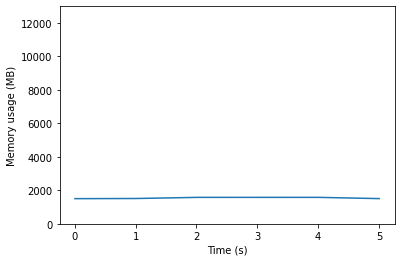

In [61]:
runtime_stats = pd.DataFrame(columns=['SeriesInstanceUID','download_time',
                                      'NiftiConverter_time', 'cpu_usage','ram_usage_mb', 'ram_total_mb'
                                      ])
if __name__ == "__main__":
    for series_id in SeriesInstanceUIDs:
        with ThreadPoolExecutor() as executor:
            monitor = MemoryMonitor()
            mem_thread = executor.submit(monitor.measure_usage)
            try:
                proc_thread = executor.submit(download_and_process_series, series_id)
                proc_thread.result()
            finally:
                monitor.keep_measuring = False
                cpu_usage, ram_usage_mb, time_stamps, ram_total_mb = mem_thread.result()
                
                cpu_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[cpu_idx, runtime_stats.columns.get_loc('cpu_usage')] = [[cpu_usage]]

                ram_usage_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_usage_mb_idx, runtime_stats.columns.get_loc('ram_usage_mb')] = [[ram_usage_mb]]
                
                ram_total_mb_idx = runtime_stats.index[runtime_stats['SeriesInstanceUID'] == series_id][0]
                runtime_stats.iloc[ram_total_mb_idx, runtime_stats.columns.get_loc('ram_total_mb')] = [[ram_total_mb]]
                
                
                #runtime_stats.at[runtime_stats['SeriesInstanceUID']==series_id, 'cpu_usage']=[[cpu_usage]]
                #runtime_stats.at[runtime_stats['SeriesInstanceUID']==series_id, 'ram_usage_mb']=[[ram_usage_mb]]
                #runtime_stats.at[runtime_stats['SeriesInstanceUID']==series_id, 'ram_total_mb']=[[ram_total_mb]]

                plt.plot(time_stamps, cpu_usage)
                plt.ylim(0, 100)
                plt.xlabel('Time (s)')
                plt.ylabel('CPU usage (%)')
                plt.show()

                plt.plot(time_stamps, ram_usage_mb)
                plt.ylim(0, ram_total_mb)
                plt.xlabel('Time (s)')
                plt.ylabel('Memory usage (MB)')
                plt.show()


###Utilization Metrics

In [66]:
runtime_stats['csv_read_time']=read_time
runtime_stats

,SeriesInstanceUID,download_time,NiftiConverter_time,cpu_usage,ram_usage_mb,ram_total_mb,csv_read_time
0,1.3.6.1.4.1.14519.5.2.1.7009.9004.946109466334...,1.251547,9.034280,"[[[21.6, 87.6, 75.1, 97.5, 100.0, 100.0, 100.0...","[[[1490.2734375, 1586.5546875, 1636.1640625, 1...",[12985.546875],0.013532
1,1.2.840.113654.2.55.99651797089556982668213819...,0.960382,4.057861,"[[[77.5, 84.4, 94.0, 100.0, 100.0, 89.1]]]","[[[1501.76171875, 1510.9765625, 1578.0859375, ...",[12985.546875],0.013532


###Monitoring for dcm2niix Errors

In [63]:
import os
import csv

def check_dcm2niix_errors(path):
    with open('dcm2niix_errors.csv', 'w') as csvfile:
        writer = csv.writer(csvfile)
        for series_id in os.listdir(path):
            series_id_path = os.path.join(path, series_id)
            if os.path.isdir(series_id_path):
                num_files = len([f for f in os.listdir(series_id_path) if os.path.isfile(os.path.join(series_id_path, f))])
                if num_files > 1:
                    print(f'Found one more than one nifti for the {series_id}')
                    writer.writerow([series_id])
                    shutil.rmtree(f'dcm2niix/{series_id}')


In [64]:
check_dcm2niix_errors(f'/{curr_dir}/dcm2niix')

Found one more than one nifti for the 1.3.6.1.4.1.14519.5.2.1.7009.9004.946109466334058509440732472138
Found one more than one nifti for the 1.2.840.113654.2.55.99651797089556982668213819691341139949


###Zipping Output Files


In [65]:
runtime_stats.to_csv('runtime.csv')
!zip -j -r downloadDicomAndConvertUsageMetrics.zip  {curr_dir}/runtime.csv
!zip -j -r downloadDicomAndConvertNiftiFiles.zip {curr_dir}/dcm2niix
#!zip -j -r downloadDicomAndConvertNiftiFiles.zip {curr_dir}/plastimatch

updating: runtime.csv (deflated 48%)

zip error: Nothing to do! (try: zip -j -r downloadDicomAndConvertNiftiFiles.zip . -i /content/dcm2niix)
